## Data Visualization with OpenAI Assistants API

In this example, we upload a simple CSV file containing the earnings and spending of a person by month in a year. We ask the AI assistant to draw some insights from this data and provide us with 3 graphs that helps in visualizing the data and insights. 

### Environment Setup

In [ ]:
!pip install openai
!pip install python-dotenv
!pip install pillow
!pip install termcolor

In [1]:
from openai import OpenAI
import os
from dotenv import load_dotenv
import json
import time
from PIL import Image

### OpenAI API Setup

The OpenAI API key is placed in a `.env` file. If you don't have one, create a file named `.env` and update with the following. Replace `sk_this_is_a_sample_key` with your OpenAI API key.

`OPENAI_API_KEY=sk_this_is_a_sample_key`

In [2]:
_ = load_dotenv()

client = OpenAI(
    api_key = os.environ['OPENAI_API_KEY']
)

### Create the assistant

In [3]:
assistant = client.beta.assistants.create(
  name="Data visualizer",
  description='''You are great at creating beautiful data visualizations. 
  Your task is to analyze data present in .csv files, understand trends, 
  come up with data visualizations relevant to those trends and provide a brief summary of the trends observed.''',
  model="gpt-4-1106-preview",
  tools=[{"type": "code_interpreter"}],
)

### Upload a file

The CSV file can be downloaded from here - [savings-2023.csv](). It needs to be placed in the same directory where this Jupyter Notebook is placed. 

In [4]:
file = client.files.create(
  file=open("savings-2023.csv", "rb"),
  purpose='assistants'
)

### Create a new thread

In [5]:
# Pass in the uploaded file along with the user message
thread = client.beta.threads.create(
  messages=[
    {
      "role": "user",
      "content": "Create 3 data visualizations based on the trends in this file.",
      "file_ids": [file.id]
    }
  ]
)

### Run the assistant

In [6]:
run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id
)

### Check the status of the run

We need to poll a few times to retrieve the latest run status until it returns `completed`. Run this cell in a few seconds interval until it prints `completed`. There is a little helper function at the end of this notebook which would automate that polling process. 

In [12]:
run_retrieved = client.beta.threads.runs.retrieve(
    thread_id=thread.id,
    run_id=run.id
)

run_retrieved.status

'completed'

### Display the response

In [13]:
messages = client.beta.threads.messages.list(
  thread_id=thread.id
)

In [14]:
message_json = json.loads(messages.model_dump_json())
print(json.dumps(message_json, indent=2))

{
  "data": [
    {
      "id": "msg_eYmOPGB206G39K0KL05T7UNx",
      "assistant_id": "asst_3NheKcq2odgizxz9dgVcgokI",
      "content": [
        {
          "image_file": {
            "file_id": "file-jf1OiKalYJX2TRyCIDrDrr93"
          },
          "type": "image_file"
        },
        {
          "text": {
            "annotations": [],
            "value": "Here are three data visualizations based on the trends in the file you provided:\n\n1. The first chart on the left shows the trend of Earnings over time.\n2. The middle chart displays the trend of Savings over time.\n3. The chart on the right is a combined line chart displaying both Earnings and Savings to compare how they vary with each other over time.\n\nEach data point is marked with a circle, and the dates on the x-axis are rotated to make them more legible. If you need any modifications or have any other specific requests for these visualizations, please let me know!"
          },
          "type": "text"
        }
    

In [15]:
from termcolor import colored

def pretty_print_conversation(messages):
    role_to_color = {
        "system": "red",
        "user": "green",
        "assistant": "blue",
        "function": "magenta",
        "other": "yellow"
    }

    for data in messages.data:
        if data.role == "assistant":
            printAssistantMessage(data, role_to_color)
        elif data.role == "user":
            printUserMessage(data, role_to_color)
        else:
            printOtherMessage(data, role_to_color)

def printAssistantMessage(data, role_to_color):
    for content in data.content:
        if content.type == "image_file":
            print(colored(f"assistant: Image File Id = {content.image_file.file_id}\n", role_to_color[data.role]))
        elif content.type == "text":
            print(colored(f"assistant: {content.text.value}\n", role_to_color[data.role]))
    print(colored("**********\n", "cyan"))

def printUserMessage(data, role_to_color):
    for content in data.content:
        print(colored(f"user: {content.text.value}\n", role_to_color[data.role]))

def printOtherMessage(data, role_to_color):
    for content in data.content:
        print(colored(f"{data.role}: {content.text.value}\n", role_to_color[data.role]))

In [16]:
pretty_print_conversation(messages)

assistant: Image File Id = file-jf1OiKalYJX2TRyCIDrDrr93

assistant: Here are three data visualizations based on the trends in the file you provided:

1. The first chart on the left shows the trend of Earnings over time.
2. The middle chart displays the trend of Savings over time.
3. The chart on the right is a combined line chart displaying both Earnings and Savings to compare how they vary with each other over time.

Each data point is marked with a circle, and the dates on the x-axis are rotated to make them more legible. If you need any modifications or have any other specific requests for these visualizations, please let me know!

**********

assistant: The file appears to be in CSV format and contains columns for `Month-Year`, `Earnings`, and `Savings`. The dataset includes at least five rows of data.

Now that we have the data loaded, we can proceed with creating visualizations. Given the nature of the data, here are three potential visualizations we could create:

1. A line cha

### Retrieve file content

https://platform.openai.com/docs/api-reference/files/retrieve-contents

### Use Pillow library to load the image and display it

In [17]:
from PIL import Image

In [18]:
def get_images(messages):
    image_files = []
    for data in messages.data:
        if data.role == "assistant":
            for content in data.content:
                if content.type == "image_file":
                    image = client.files.content(content.image_file.file_id)
                    image_files.append(image)
        else: 
            break
    return image_files

def get_new_dimensions(original_dimension, custom_width, custom_height):
    original_width, original_height = original_dimension
    aspect_ratio = original_width / original_height

    # Calculate the new dimensions while maintaining the aspect ratio
    if custom_width / aspect_ratio <= custom_height:
        new_width = custom_width
        new_height = int(new_width / aspect_ratio)
    else:
        new_height = custom_height
        new_width = int(new_height * aspect_ratio)

    return (new_width, new_height)

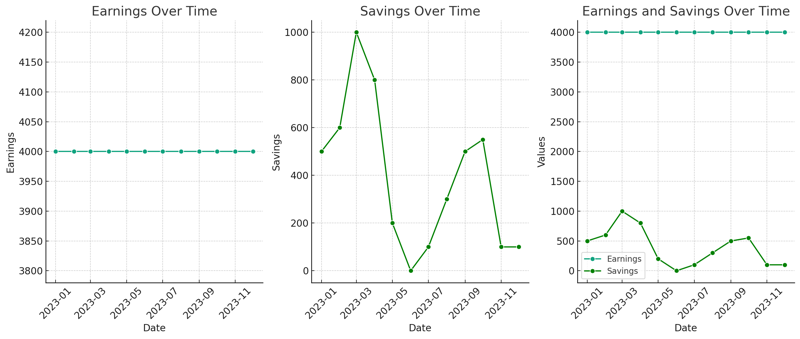

In [19]:
# Get the images from assistant response
image_files = get_images(messages) 
for image_file in image_files:
    image = Image.open(image_file)
    new_width, new_height = get_new_dimensions(image.size, 800, 600)
    resized_image = image.resize((new_width, new_height))
    resized_image.show()

### Use a polling function and callback

The polling function - `get_assistant_response()` - will loop through a specified number of times at regular intervals to retrieve the run status. Once the run status turns to `completed`, it will invoke a callback function - `handle_response()` - to display the conversation and the images that the AI assistant generated. 

In [20]:
# The function to poll the run status in a regular interval for a specified amount of times
def get_assistant_response(thread_id, run_id, callback, interval=10, max_attempts=60):
    attempts = 0
    while attempts < max_attempts:
        try:
            updated_run = client.beta.threads.runs.retrieve(
              thread_id=thread_id,
              run_id=run_id
            )
            status = updated_run.status
            # Check if the status indicates completion
            if status == "completed":
                callback(status, thread_id)
                break
            else:
                callback(f"Run status: {status}")
                
            time.sleep(interval)
            attempts += 1   
        except Exception as e:
            callback(f"Error: {str(e)}")
            time.sleep(interval)
            attempts += 1
    else:
        # If max_attempts reached without completion, call the callback with a timeout message
        callback("Timeout: Assistant didn't respond in time. Please try again.")

# Callback function to handle the run status
def handle_response(status, thread_id=None):
    if status == "completed":
        print("Run completed successfully.")
        display_messages(thread_id)
    else:
        print(status)

# Function to display the assistant's response
def display_messages(thread_id):
    messages = client.beta.threads.messages.list(
      thread_id=thread_id
    )

    # Print the conversation
    pretty_print_conversation(messages)

    # Display the visualizations created by the assistant
    image_files = get_images(messages) 
    for image_file in image_files:
        image = Image.open(image_file)
        new_width, new_height = get_new_dimensions(image.size, 800, 600)
        resized_image = image.resize((new_width, new_height))
        resized_image.show()

Let's create a new thread and a new run to invoke the assistant again using the above utility functions and display the reponse

In [21]:
thread_1 = client.beta.threads.create(
  messages=[
    {
      "role": "user",
      "content": "Create 3 data visualizations based on the trends in this file.",
      "file_ids": [file.id]
    }
  ]
)

In [22]:
run_1 = client.beta.threads.runs.create(
    thread_id=thread_1.id,
    assistant_id=assistant.id
)

Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run completed successfully.
assistant: Image File Id = file-hKtsG1WowdbZaorTFs9c0IR4

assistant: The pie chart above displays the proportion of total earnings to total savings. The larger section represents the total earnings, while the smaller section represents total savings. The "explode" feature on the earnings slice emphasizes it relative to savings.

These three visualizations should provide various insights into the financial trends of earnings and savings presented in the data. If you have any other specific types of visualizations in mind or further questions, feel free to ask!

**********

assistant: Image File Id = file-jrSFmfH12FBPzxZxadbbdkSC

assistant: The bar plot above compares "Earnings" and "Savings" for each month. The total heigh

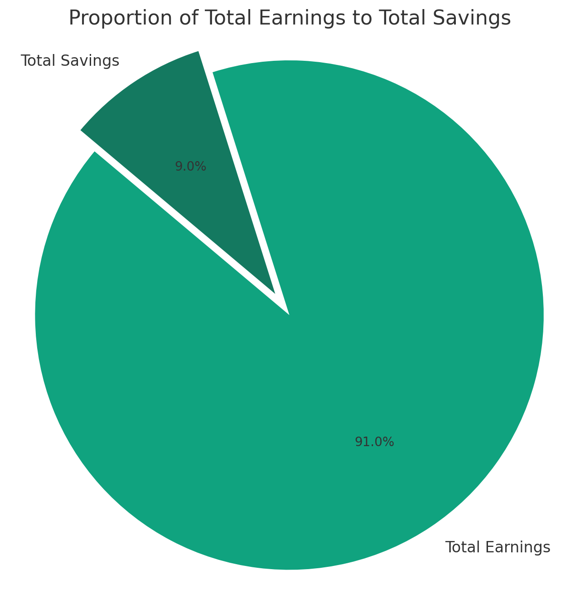

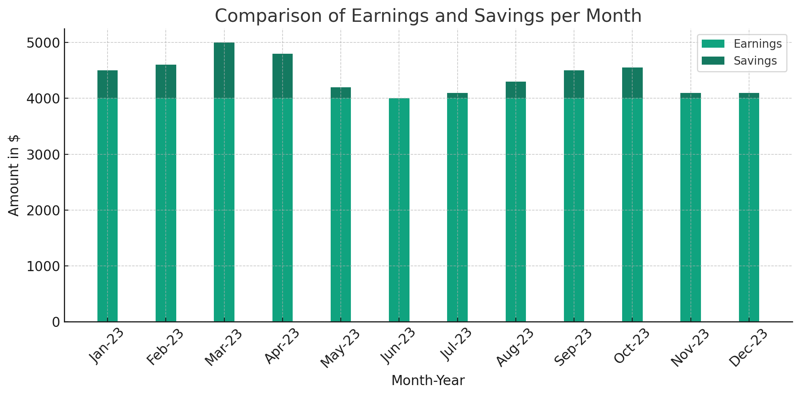

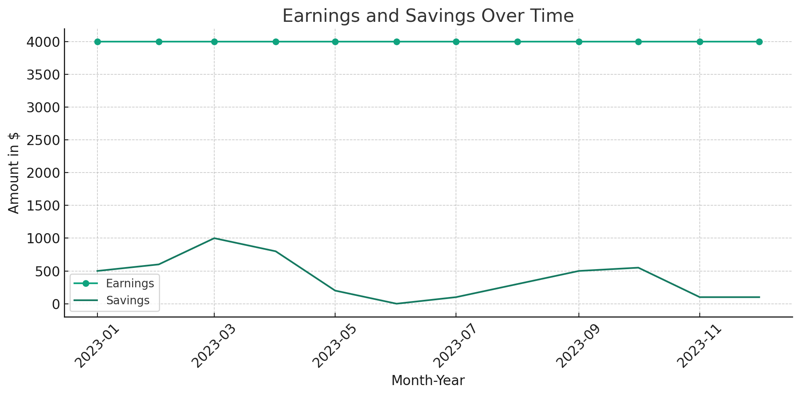

In [23]:
get_assistant_response(thread_1.id, run_1.id, handle_response)